Load libraries etc:

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1 #what portion of gpu to use
session = tf.Session(config=config)
keras.backend.set_session(session)

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Add, Lambda, add
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data
from skimage.io import imread

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [3]:
from keras.backend import resize_images
from skimage.transform import resize

Load train and test data: (Well, this will only work if you input the path to the data in mainDir, which currently is not public)

In [4]:
from pathlib import Path

classes = ['BUBBLES_v3','CLEAR_BLOB','DILATED','TURBID_v2','UNDEFINED','WALL','WRINKLES_v2']
#classes = ['BUBBLES_v3','CLEAR_BLOB','DILATED','UNDEFINED','WALL','WRINKLES_v2']
mainDir = '../../data/intestins/original/'

In [5]:
img_per_class = 500
img_per_test = 100
cls = 0
data = {}
X_train = np.empty([7*img_per_class,256,256,3])
y_train = np.zeros([7*img_per_class])
X_test = np.empty([7*img_per_test,256,256,3])
y_test = np.zeros([7*img_per_test])
for c in classes:
    cnt = 0
    curDir = mainDir + c
    pathlist = Path(curDir).glob('*')
    for path in pathlist:
        path_str = str(path)
        if "png" not in path_str and "jpg" not in path_str and "bmp" not in path_str:
            continue
        if "r180" in path_str or "r90" in path_str:
            continue
        im = imread(path_str)
        imarray = np.array(im)
        imresized = resize(imarray, (256,256), mode='symmetric')
        if cnt >= img_per_class + img_per_test:
            break
        elif cnt >= img_per_class:
            X_test[cls * img_per_test + cnt - img_per_class] = imresized
            y_test[cls * img_per_test + cnt - img_per_class] = cls
        else:
            X_train[cls * img_per_class + cnt] = imresized
            y_train[cls * img_per_class + cnt] = cls
        cnt += 1
    cls += 1

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3500, 256, 256, 3)
(3500,)
(700, 256, 256, 3)
(700,)


Define the GAN and the load the pretrained weights:

In [34]:
# Large amount of credit goes to:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
# which I've used as a reference for this implementation
# Author: Hanling Wang
# Date: 2018-11-21

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np
from keras.utils import to_categorical

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.nclasses = 7
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        
        # Build and compile the classifier
        self.classifier = self.build_classifier()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True
        self.classifier.trainable = False

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Classify fake images
        classified = self.classifier([img])
        # Defines generator model
        self.generator_model = Model([z_gen, label], [valid, classified])
        self.generator_model.compile(loss=[self.wasserstein_loss, 'categorical_crossentropy'], optimizer=optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_classifier(self):

        model = Sequential()
        model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(7, activation="softmax"))
        return model

    def build_generator(self):

        dropout = 0.4
        depth = 256
        dim = 8
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 8 x 8 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        u1 = UpSampling2D()(d) # 16 x 16 x 256
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(u1) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 32 x 32 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 64 x 64 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])
        u4 = UpSampling2D()(a3) # 128 x 128 x 32
        
        c13 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(u4) # 128 x 128 x 16
        c13 = BatchNormalization(momentum=0.9)(c13)
        
        c14 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c13) # 128 x 128 x 16
        c14 = BatchNormalization(momentum=0.9)(c14)
        
        c15 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c14) # 128 x 128 x 16
        c15 = BatchNormalization(momentum=0.9)(c15)
        
        c16 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c15) # 128 x 128 x 16
        c16 = BatchNormalization(momentum=0.9)(c16)
        
        a4 = Add()([c13, c16])
        u5 = UpSampling2D()(a4) # 256 x 256 x 16
        
        c17 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(u5) # 256 x 256 x 8
        c17 = BatchNormalization(momentum=0.9)(c17)
        
        c18 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(c17) # 256 x 256 x 8
        c18 = BatchNormalization(momentum=0.9)(c18)
        
        c19 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(c18) # 256 x 256 x 8
        c19 = BatchNormalization(momentum=0.9)(c19)
        
        c20 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(c19) # 256 x 256 x 8
        c20 = BatchNormalization(momentum=0.9)(c20)
        
        a5 = Add()([c17, c20])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(3, 5, padding='same')(a5) # 256 x 256 x 3
        
        model = Model(inputs = [noise, label], output = generated_img) 
        model.summary()
        return model

    def build_critic(self):
        
        depth = 16
        dropout = 0.2

        img = Input(shape=self.img_shape)
        flat_img = Flatten()(img)
        
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.nclasses, np.prod(self.img_shape))(label))
        
        model_img = multiply([flat_img, label_embedding])
        model_img = Reshape(self.img_shape)(model_img)
        
        c1 = Conv2D(depth, 5, strides=2, padding='same')(model_img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        #c1 = Dropout(dropout)(c1) # 64 x 64 x 32
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        #c2 = Dropout(dropout)(c2) # 64 x 64 x 32
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        #c3 = Dropout(dropout)(c3) # 64 x 64 x 32
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        #c4 = Dropout(dropout)(c4) # 64 x 64 x 32
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        #c5 = Dropout(dropout)(c5) # 32 x 32 x 64
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        #c6 = Dropout(dropout)(c6) # 32 x 32 x 64
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        #c7 = Dropout(dropout)(c7) # 32 x 32 x 64
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        #c8 = Dropout(dropout)(c8) # 32 x 32 x 64
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        #c9 = Dropout(dropout)(c9) # 16 x 16 x 128
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        #c10 = Dropout(dropout)(c10) # 16 x 16 x 128
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        #c11 = Dropout(dropout)(c11) # 16 x 16 x 128
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        #c12 = Dropout(dropout)(c12) # 16 x 16 x 128
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*4, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 8 x 8 x 256
        
        c14 = Conv2D(depth*4, 5, padding='same')(c13)
        c14 = LeakyReLU(alpha=0.2)(c14) # 8 x 8 x 256
        
        c15 = Conv2D(depth*4, 5, padding='same')(c14)
        c15 = LeakyReLU(alpha=0.2)(c15) # 8 x 8 x 256
        
        c16 = Conv2D(depth*4, 5, padding='same')(c15)
        c16 = LeakyReLU(alpha=0.2)(c16) # 8 x 8 x 256
        
        a4 = Add()([c13, c16])
        
        c17 = Conv2D(depth*8, 5, strides=2, padding='same')(a4)
        c17 = LeakyReLU(alpha=0.2)(c17) # 8 x 8 x 256
        
        c18 = Conv2D(depth*8, 5, padding='same')(c17)
        c18 = LeakyReLU(alpha=0.2)(c18) # 8 x 8 x 256
        
        c19 = Conv2D(depth*8, 5, padding='same')(c18)
        c19 = LeakyReLU(alpha=0.2)(c19) # 8 x 8 x 256
        
        c20 = Conv2D(depth*8, 5, padding='same')(c19)
        c20 = LeakyReLU(alpha=0.2)(c20) # 8 x 8 x 256
        
        a5 = Add()([c17, c20])
        
        c21 = Conv2D(depth*16, 5, strides=2, padding='same')(a5)
        c21 = LeakyReLU(alpha=0.2)(c21) # 4 x 4 x 512

        f = Flatten()(c21)
        validity = Dense(1)(f)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model
    
    def train_classifier(self, X_train, y_train):
        
        y_train_one_hot = to_categorical(y_train, 7)
        
        # Train the classifier
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.classifier.fit(X_train, y_train_one_hot, batch_size=100, epochs=50, verbose=1)
    

    def train(self, X_train, y_train):

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        
        # set up tensorboard
        writer = tf.summary.FileWriter('./logs')
        writer_hist = tf.summary.FileWriter('./hists')
        
        g_loss = None
        d_loss = None
        
        summary = tf.Summary()
        summary.value.add(tag='generator', simple_value=g_loss)
        summary.value.add(tag='discriminator', simple_value=d_loss)
        
        
        for epoch in range(self.epochs):
            for _ in range(self.n_critic):
                
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.nclasses, self.batch_size).reshape(-1, 1)
            labels_one_hot = to_categorical(sampled_labels, 7)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], [valid, labels_one_hot])

            # Add results to tensorboard
            summary.value[0].simple_value = g_loss[0]
            summary.value[1].simple_value = d_loss[0]
            writer.add_summary(summary, epoch)
            
            #d_pred = self.critic_model.predict_on_batch([imgs, labels, noise])
            #log_histogram(writer_hist, 'discriminator_preds', d_pred, epoch, bins=1000)
            
            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('generator2', overwrite=True)
                self.critic.save_weights('discriminator2', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))

    def sample_images(self, epoch):
        r, c = 10, 7
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array(list(range(7))*10).reshape(-1, 1)
        
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = self.combine_images(gen_imgs)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(figsize=(20, 14))
        plt.imshow(gen_imgs)
        plt.axis('off')
        plt.savefig("images2/intestines_%d.png" % epoch)
        plt.close()
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = 10
        height = 7
        shape = generated_images.shape[1:3]
        image = np.zeros((width*shape[0], height*shape[1], 3),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            j = int(index/width)
            i = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
                img[:, :, :]
        return image
    
    def generate_images(self, label):
        self.generator.load_weights('../cwgan_gp/generator')
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape(-1,1)])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
        
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        plt.axis('off')

        plt.close()

if __name__ == '__main__':
    epochs = 1
    batch_size = 32
    sample_interval = 100
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.critic.load_weights('discriminator')
    wgan.generator.load_weights('generator')

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:268: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       700         input_11[0][0]                   
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 100)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
concatenat

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:374: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 196608)    1376256     input_13[0][0]                   
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 196608)       0           input_12[0][0]                   
__________________________________________________________________________________________________
flatten_11

Generate images:

In [ ]:
D = wgan.critic
G = wgan.generator

In [ ]:
num = 7000
noise = np.random.uniform(-1.0, 1.0, size=[num, 100])
labels = np.arange(0, 7).repeat(num/7).reshape(-1, 1)
images_fake = G.predict([noise, labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

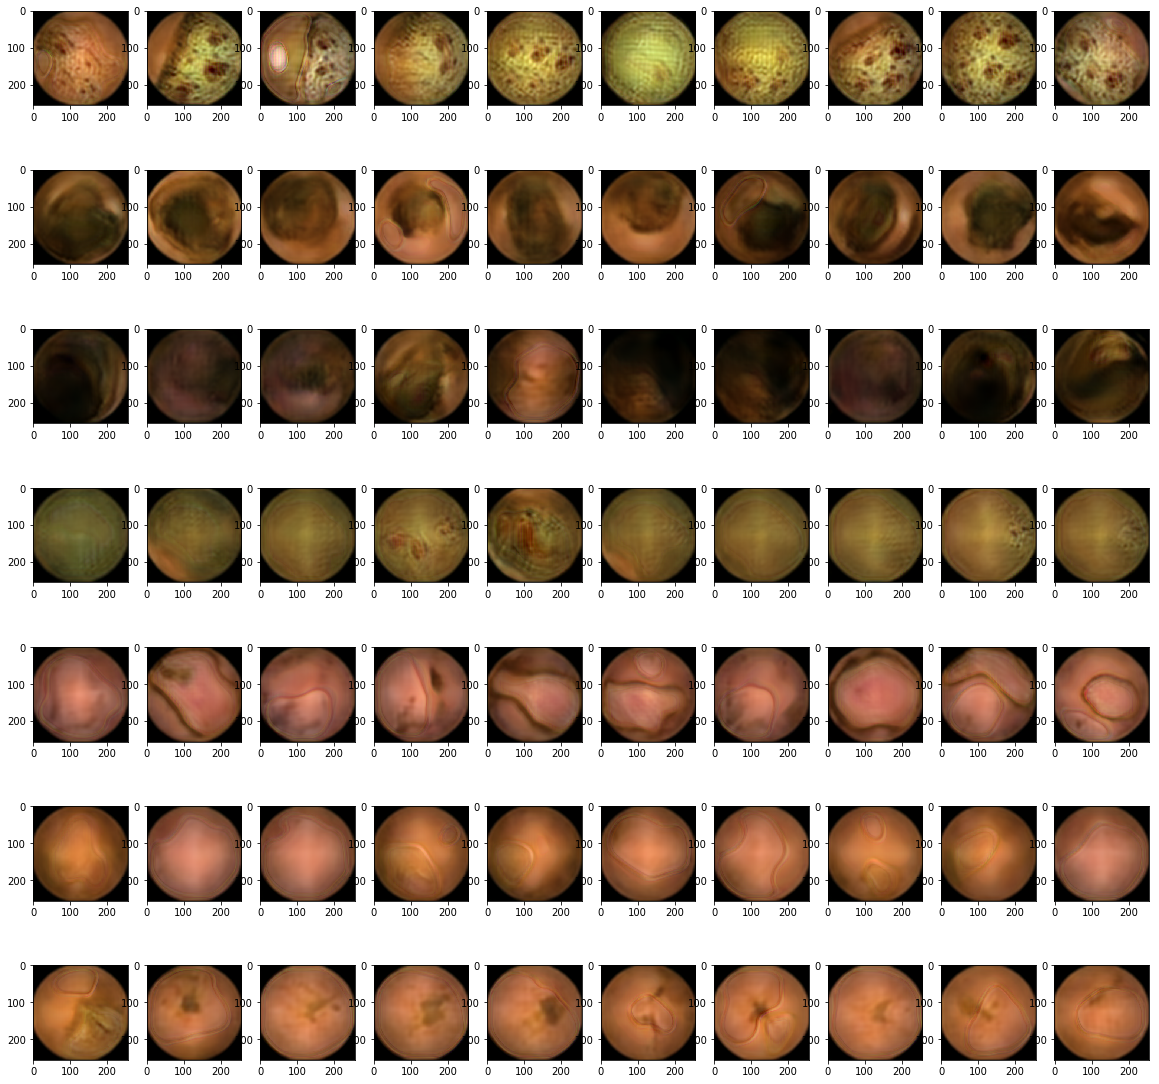

In [12]:
fig, axs = plt.subplots(7, 10,figsize=(20, 20))
cnt = 0
for i in range(7):
    for j in range(10):
        axs[i,j].imshow(images_fake[cnt,:,:,:])
        cnt += 1
    cnt += 1000
plt.show()
plt.close()

Train the classifier to attempt scoring using IS. The produced score isn't sensible, not sure why. We adapted the code that uses the Inception network to use our classifier instead, but maybe that's not how this should be done.

In [ ]:
wgan.train_classifier(X_train, y_train)
C = wgan.classifier

In [15]:
'''
Adapted from code found in https://github.com/tsc2017/Inception-Score,
further derived from https://github.com/openai/improved-gan/blob/master/inception_score/model.py and https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/eval/python/classifier_metrics_impl.py
'''

import tensorflow as tf
import os, sys
import functools
import numpy as np
import time

# A smaller BATCH_SIZE reduces GPU memory usage, but at the cost of a slight slowdown
BATCH_SIZE = 64

def get_inception_probs(inps):
    n_batches = len(inps) // BATCH_SIZE
    preds = np.zeros([n_batches * BATCH_SIZE, 7], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * BATCH_SIZE:(i + 1) * BATCH_SIZE] / 255. * 2 - 1
        preds[i * BATCH_SIZE:(i + 1) * BATCH_SIZE] = C.predict(inp)
    preds = np.exp(preds) / np.sum(np.exp(preds), 1, keepdims=True)
    return preds

def preds2score(preds, splits=10):
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

def get_inception_score(images, splits=10):
    assert(type(images) == np.ndarray)
    assert(len(images.shape) == 4)
    assert(np.min(images[0]) >= 0 and np.max(images[0]) > 10), 'Image values should be in the range [0, 255]'
    print('Calculating Inception Score with %i images in %i splits' % (images.shape[0], splits))
    start_time=time.time()
    preds = get_inception_probs(images)
    mean, std = preds2score(preds, splits)
    print('Inception Score calculation time: %f s' % (time.time() - start_time))
    return mean, std

In [16]:
get_inception_score((images_fake*0.5 + 0.5)*254)

Calculating Inception Score with 7000 images in 10 splits
Inception Score calculation time: 19.739621 s


(1.0253062, 0.017112365)

In [ ]:
Define the first classifier for evaluation purpose - train on the train data, test on the

In [13]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
model.add(ZeroPadding2D(padding=((0,1),(0,1))))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(7, activation="softmax"))

In [14]:
y_train_one_hot = to_categorical(y_train, 7)
        
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_one_hot, batch_size=100, epochs=25, verbose=1)

Epoch 1/25
3500/3500 [==============================] - 22s 6ms/step - loss: 5.7248 - acc: 0.3614
Epoch 2/25
3500/3500 [==============================] - 19s 5ms/step - loss: 5.3833 - acc: 0.4709
Epoch 3/25
3500/3500 [==============================] - 18s 5ms/step - loss: 5.2809 - acc: 0.4949
Epoch 4/25
3500/3500 [==============================] - 18s 5ms/step - loss: 5.1500 - acc: 0.5206
Epoch 5/25
3500/3500 [==============================] - 18s 5ms/step - loss: 5.0092 - acc: 0.5360
Epoch 6/25
3500/3500 [==============================] - 18s 5ms/step - loss: 2.5757 - acc: 0.5943
Epoch 7/25
3500/3500 [==============================] - 18s 5ms/step - loss: 1.5075 - acc: 0.6820
Epoch 8/25
3500/3500 [==============================] - 19s 5ms/step - loss: 1.2498 - acc: 0.7203
Epoch 9/25
3500/3500 [==============================] - 18s 5ms/step - loss: 1.1096 - acc: 0.7351
Epoch 10/25
3500/3500 [==============================] - 18s 5ms/step - loss: 1.1200 - acc: 0.7486
Epoch 11/25
3500/35

In [15]:
y_test_one_hot = to_categorical(y_test, 7)
model.evaluate(X_test,y_test_one_hot)

700/700 [==============================] - 3s 5ms/step


[1.0363079752240862, 0.7585714278902327]

In [17]:
y_fake_one_hot = to_categorical(labels, 7)
model.evaluate(images_fake,y_fake_one_hot)

7000/7000 [==============================] - 11s 2ms/step


[0.4188892624037606, 0.9087142856461661]

In [18]:
model2 = Sequential()
model2.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
model2.add(LeakyReLU(alpha=0.2))
model2.add(Dropout(0.25))
model2.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
model2.add(ZeroPadding2D(padding=((0,1),(0,1))))
model2.add(BatchNormalization(momentum=0.8))
model2.add(LeakyReLU(alpha=0.2))
model2.add(Dropout(0.25))
model2.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
model2.add(BatchNormalization(momentum=0.8))
model2.add(LeakyReLU(alpha=0.2))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
model2.add(BatchNormalization(momentum=0.8))
model2.add(LeakyReLU(alpha=0.2))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(7, activation="softmax"))

In [19]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(images_fake, y_fake_one_hot, batch_size=100, epochs=25, verbose=1)

Epoch 1/25
7000/7000 [==============================] - 30s 4ms/step - loss: 0.8802 - acc: 0.8033
Epoch 2/25
7000/7000 [==============================] - 27s 4ms/step - loss: 0.1358 - acc: 0.9629
Epoch 3/25
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1164 - acc: 0.9729
Epoch 4/25
7000/7000 [==============================] - 26s 4ms/step - loss: 0.0884 - acc: 0.9783
Epoch 5/25
7000/7000 [==============================] - 27s 4ms/step - loss: 0.0736 - acc: 0.9863
Epoch 6/25
7000/7000 [==============================] - 26s 4ms/step - loss: 0.0364 - acc: 0.9919
Epoch 7/25
7000/7000 [==============================] - 26s 4ms/step - loss: 0.0527 - acc: 0.9881
Epoch 8/25
7000/7000 [==============================] - 27s 4ms/step - loss: 0.0332 - acc: 0.9940
Epoch 9/25
7000/7000 [==============================] - 26s 4ms/step - loss: 0.0179 - acc: 0.9967
Epoch 10/25
7000/7000 [==============================] - 26s 4ms/step - loss: 0.0110 - acc: 0.9956
Epoch 11/25
7000/70

In [22]:
model2.evaluate(X_train, y_train_one_hot)

3500/3500 [==============================] - 12s 3ms/step


[3.730943517957415, 0.6622857142857143]

In [23]:
model2.evaluate(X_test, y_test_one_hot)

700/700 [==============================] - 2s 3ms/step


[4.0429950564248225, 0.6314285710879735]

In [24]:
all_train = np.concatenate((X_train, images_fake), axis=0)

In [25]:
all_train.shape

(10500, 256, 256, 3)

In [26]:
all_labels_one_hot = np.concatenate((y_train_one_hot, y_fake_one_hot), axis=0)

In [27]:
all_labels_one_hot.shape

(10500, 7)

In [28]:
model3 = Sequential()
model3.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
model3.add(LeakyReLU(alpha=0.2))
model3.add(Dropout(0.25))
model3.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
model3.add(ZeroPadding2D(padding=((0,1),(0,1))))
model3.add(BatchNormalization(momentum=0.8))
model3.add(LeakyReLU(alpha=0.2))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
model3.add(BatchNormalization(momentum=0.8))
model3.add(LeakyReLU(alpha=0.2))
model3.add(Dropout(0.25))
model3.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
model3.add(BatchNormalization(momentum=0.8))
model3.add(LeakyReLU(alpha=0.2))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(7, activation="softmax"))

In [32]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(all_train, all_labels_one_hot, batch_size=100, epochs=25, verbose=1)

Epoch 1/25
10500/10500 [==============================] - 77s 7ms/step - loss: 0.0880 - acc: 0.9754
Epoch 2/25
10500/10500 [==============================] - 56s 5ms/step - loss: 0.0719 - acc: 0.9779
Epoch 3/25
10500/10500 [==============================] - 56s 5ms/step - loss: 0.1004 - acc: 0.9738
Epoch 4/25
10500/10500 [==============================] - 56s 5ms/step - loss: 0.0755 - acc: 0.9802
Epoch 5/25
10500/10500 [==============================] - 56s 5ms/step - loss: 0.0907 - acc: 0.9795
Epoch 6/25
10500/10500 [==============================] - 56s 5ms/step - loss: 0.0734 - acc: 0.9805
Epoch 7/25
10500/10500 [==============================] - 56s 5ms/step - loss: 0.0637 - acc: 0.9841
Epoch 8/25
10500/10500 [==============================] - 57s 5ms/step - loss: 0.0522 - acc: 0.9855
Epoch 9/25
10500/10500 [==============================] - 57s 5ms/step - loss: 0.0502 - acc: 0.9850
Epoch 10/25
10500/10500 [==============================] - 57s 5ms/step - loss: 0.0374 - acc: 0.9898

In [31]:
model3.evaluate(X_test, y_test_one_hot)

700/700 [==============================] - 4s 6ms/step


[1.2935013256754193, 0.7828571425165449]